In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import numpy as np
import time
import random
from matplotlib import pyplot as plt
from easydict import EasyDict as edict
from pathlib import Path
import torch
from functools import partial

import torchvision.transforms as transforms
import torchvision.datasets as dset

In [29]:
from iterative_sir.models.dcgan import Discriminator, Generator
from iterative_sir.sampling_utils.distributions import IndependentNormal
from iterative_sir.sampling_utils.ebm_sampling import (
    langevin_dynamics,
    grad_energy,
    gan_energy)

from iterative_sir.sampling_utils.metrics import inception_score

# Test model from https://github.com/csinva/gan-vae-pretrained-pytorch

In [30]:
models_mnist_scratch_path = Path('../models/mnist')
d_path = Path(models_mnist_scratch_path, "netD_epoch_99.pth")
g_path = Path(models_mnist_scratch_path, "netG_epoch_99.pth")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dckpt = torch.load(d_path, map_location=device)
gckpt = torch.load(g_path, map_location=device)

In [31]:
D = Discriminator(ngpu=1).eval()
G = Generator(ngpu=1).eval()

D.load_state_dict(dckpt)
G.load_state_dict(gckpt)

D = D.eval()
G = G.eval()

G = G.to(device)
D = D.to(device)

In [32]:
from torch import nn


class Discriminator_logits(nn.Module):
    def __init__(self, discriminator_sigmoid, ngpu):
        super(Discriminator_logits, self).__init__()
        self.ngpu = ngpu
        self.main = discriminator_sigmoid.main[:-1]

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

In [33]:
D_logits = Discriminator_logits(D, ngpu=1).eval()

In [8]:
batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1).to(device)
fake_images = G(fixed_noise)

In [9]:
print(fake_images.shape)
print(fake_images.min())
print(fake_images.max())

torch.Size([25, 1, 28, 28])
tensor(-1., grad_fn=<MinBackward1>)
tensor(1., grad_fn=<MaxBackward1>)


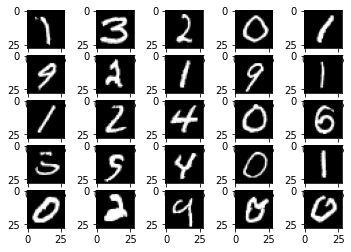

In [10]:
fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)

R, C = 5, 5

for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()

In [11]:
outputs = D(fake_images)
print(outputs)

tensor([0.1658, 0.0252, 0.0906, 0.5105, 0.1204, 0.2290, 0.0304, 0.3666, 0.5201,
        0.3168, 0.2697, 0.0087, 0.6211, 0.3635, 0.1139, 0.0093, 0.0228, 0.1293,
        0.1052, 0.3683, 0.1124, 0.8518, 0.3520, 0.6078, 0.1182],
       grad_fn=<ViewBackward>)


In [12]:
D_logits(fake_images).sigmoid()

tensor([0.1658, 0.0252, 0.0906, 0.5105, 0.1204, 0.2290, 0.0304, 0.3666, 0.5201,
        0.3168, 0.2697, 0.0087, 0.6211, 0.3635, 0.1139, 0.0093, 0.0228, 0.1293,
        0.1052, 0.3683, 0.1124, 0.8518, 0.3520, 0.6078, 0.1182],
       grad_fn=<SigmoidBackward>)

# Exloring MNIST dataset

In [13]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)

batchSize = 64

imageSize = 28

#path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'

dataset = dset.MNIST(root='../data', download=True,
                   transform=transforms.Compose([
                       transforms.Resize(imageSize),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,)),
                   ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         shuffle=True, num_workers=4)

In [14]:
data_arr = []
for images, labels in dataloader:
    print(images.min())
    print(images.max())
    print(images.shape)
    break

tensor(-1.)
tensor(1.)
torch.Size([64, 1, 28, 28])


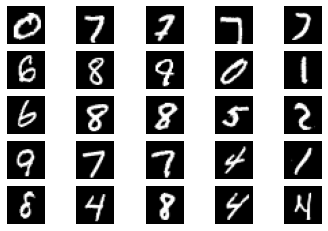

In [15]:
real_images_np = images.cpu().detach().numpy()
real_images_np = real_images_np.reshape(real_images_np.shape[0], 28, 28)

R, C = 5, 5

for i in range(25):
    plt.subplot(R, C, i + 1)
    plt.imshow(real_images_np[i], cmap='gray')
    plt.axis('off')
plt.show()

In [16]:
data_arr = []
for images, labels in dataloader:
    data_arr.append(images)
    
all_train_data = torch.cat(data_arr)
print(all_train_data.shape)

torch.Size([60000, 1, 28, 28])


In [17]:
gan_energy

<function iterative_sir.sampling_utils.ebm_sampling.gan_energy(z, generator, discriminator, proposal, normalize_to_0_1, log_prob=False, z_transform=None)>

In [34]:
z_dim = 100
loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)

proposal = IndependentNormal(
    device=device, 
    dim=z_dim, 
    loc=loc, 
    scale=scale)

def z_transform(z):
    return z.unsqueeze(-1).unsqueeze(-1)

log_prob = True
normalize_to_0_1 = True
target_gan = partial(gan_energy,
                     generator = G, 
                     discriminator = D, #D_logits, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob,
                     z_transform = z_transform)

In [35]:
z = proposal.sample((3,))
z[1:, :] = z[0, :]
o = target_gan(z)
#print(o)
_ = grad_energy(z, target_gan)

# ULA

In [39]:
batch_size = 30
n_steps = 100

In [21]:
grad_step = 1e-2 #1e-3
eps_scale = (2 * grad_step) ** .5

z = proposal.sample((batch_size,))
z[1:, :] = z[0, :]
zs = langevin_dynamics(
        z, 
        target_gan, 
        proposal, 
        n_steps,
        grad_step, 
        eps_scale
        )

In [42]:
from iterative_sir.sampling_utils.adaptive_mc import ex2_mcmc_mala

mala_steps = 1
N = 10
corr_coef = 0.9
bernoulli_prob_corr = 0.5
adapt_stepsize = True

out = ex2_mcmc_mala(
        z, 
        target_gan, 
        proposal, 
        n_steps,
        N=N,
        mala_steps=mala_steps,
        corr_coef=corr_coef,
        bernoulli_prob_corr=bernoulli_prob_corr,
        adapt_stepsize=adapt_stepsize,
        verbose=True,
        grad_step=1e-2,
        noise_scale=(2*1e-2)**.5
        )
zs = out[0]

 13%|█▎        | 13/100 [00:05<00:35,  2.44it/s]


KeyboardInterrupt: 

In [48]:
from iterative_sir.sampling_utils.ebm_sampling import mala_dynamics

adapt_stepsize = True

out = mala_dynamics(
        z, 
        target_gan, 
        proposal, 
        n_steps,
        # N=N,
        # mala_steps=mala_steps,
        # corr_coef=corr_coef,
        # bernoulli_prob_corr=bernoulli_prob_corr,
        # adapt_stepsize=adapt_stepsize,
        #verbose=True,
        grad_step=1e-2,
        eps_scale=(2*1e-2)**.5
        )
zs = out[0]

ValueError: The value argument must be within the support

In [ ]:
from iterative_sir.sampling_utils.adaptive_mc import ex2_mcmc_mala

mala_steps = 1
N = 10
corr_coef = 0.9
bernoulli_prob_corr = 0.5
adapt_stepsize = True

out = ex2_mcmc_mala(
        z, 
        target_gan, 
        proposal, 
        n_steps,
        N=N,
        mala_steps=mala_steps,
        corr_coef=corr_coef,
        bernoulli_prob_corr=bernoulli_prob_corr,
        adapt_stepsize=adapt_stepsize,
        verbose=True,
        grad_step=1e-2,
        noise_scale=(2*1e-2)**.5
        )
zs = out[0]

In [ ]:
chain = torch.stack(zs, 0)[1:, 0]

In [ ]:
out = G(chain.unsqueeze(-1).unsqueeze(-1))

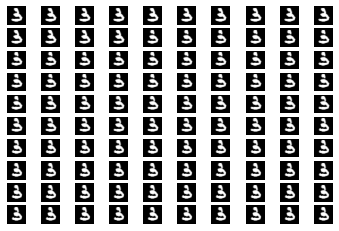

In [ ]:
images_np = out.cpu().detach().numpy()
images_np = images_np.reshape(images_np.shape[0], 28, 28)

R, C = 10, 10

for i in range(100):
    plt.subplot(R, C, i + 1)
    plt.imshow(images_np[i], cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 1000
n = 60000
n_steps = 100
grad_step = 0.01
eps_scale = 0.1
method_name = 'ula_mnist'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 10
continue_z = None

z_last_np, zs = langevin_sampling(target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z,
                                  n_steps, grad_step, eps_scale)

  2%|▏         | 1/60 [00:22<22:33, 22.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_0.npy was saved, file shape = (11, 1000, 100)



  3%|▎         | 2/60 [00:46<22:15, 23.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1000.npy was saved, file shape = (11, 1000, 100)



  5%|▌         | 3/60 [01:09<22:01, 23.18s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2000.npy was saved, file shape = (11, 1000, 100)



  7%|▋         | 4/60 [01:33<21:52, 23.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3000.npy was saved, file shape = (11, 1000, 100)



  8%|▊         | 5/60 [01:58<21:42, 23.68s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4000.npy was saved, file shape = (11, 1000, 100)



 10%|█         | 6/60 [02:22<21:28, 23.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5000.npy was saved, file shape = (11, 1000, 100)



 12%|█▏        | 7/60 [02:46<21:11, 23.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6000.npy was saved, file shape = (11, 1000, 100)



 13%|█▎        | 8/60 [03:10<20:51, 24.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7000.npy was saved, file shape = (11, 1000, 100)



 15%|█▌        | 9/60 [03:35<20:30, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8000.npy was saved, file shape = (11, 1000, 100)



 17%|█▋        | 10/60 [03:59<20:09, 24.18s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9000.npy was saved, file shape = (11, 1000, 100)



 18%|█▊        | 11/60 [04:23<19:45, 24.20s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_10000.npy was saved, file shape = (11, 1000, 100)



 20%|██        | 12/60 [04:47<19:20, 24.19s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_11000.npy was saved, file shape = (11, 1000, 100)



 22%|██▏       | 13/60 [05:11<18:56, 24.17s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_12000.npy was saved, file shape = (11, 1000, 100)



 23%|██▎       | 14/60 [05:36<18:31, 24.16s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_13000.npy was saved, file shape = (11, 1000, 100)



 25%|██▌       | 15/60 [06:00<18:07, 24.16s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_14000.npy was saved, file shape = (11, 1000, 100)



 27%|██▋       | 16/60 [06:24<17:42, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_15000.npy was saved, file shape = (11, 1000, 100)



 28%|██▊       | 17/60 [06:48<17:17, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_16000.npy was saved, file shape = (11, 1000, 100)



 30%|███       | 18/60 [07:12<16:53, 24.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_17000.npy was saved, file shape = (11, 1000, 100)



 32%|███▏      | 19/60 [07:36<16:28, 24.12s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_18000.npy was saved, file shape = (11, 1000, 100)



 33%|███▎      | 20/60 [08:00<16:04, 24.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_19000.npy was saved, file shape = (11, 1000, 100)



 35%|███▌      | 21/60 [08:24<15:40, 24.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_20000.npy was saved, file shape = (11, 1000, 100)



 37%|███▋      | 22/60 [08:49<15:16, 24.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_21000.npy was saved, file shape = (11, 1000, 100)



 38%|███▊      | 23/60 [09:13<14:52, 24.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_22000.npy was saved, file shape = (11, 1000, 100)



 40%|████      | 24/60 [09:37<14:29, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_23000.npy was saved, file shape = (11, 1000, 100)



 42%|████▏     | 25/60 [10:01<14:05, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_24000.npy was saved, file shape = (11, 1000, 100)



 43%|████▎     | 26/60 [10:25<13:41, 24.15s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_25000.npy was saved, file shape = (11, 1000, 100)



 45%|████▌     | 27/60 [10:49<13:17, 24.15s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_26000.npy was saved, file shape = (11, 1000, 100)



 47%|████▋     | 28/60 [11:13<12:52, 24.15s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_27000.npy was saved, file shape = (11, 1000, 100)



 48%|████▊     | 29/60 [11:38<12:28, 24.16s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_28000.npy was saved, file shape = (11, 1000, 100)



 50%|█████     | 30/60 [12:02<12:04, 24.16s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_29000.npy was saved, file shape = (11, 1000, 100)



 52%|█████▏    | 31/60 [12:26<11:40, 24.16s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_30000.npy was saved, file shape = (11, 1000, 100)



 53%|█████▎    | 32/60 [12:50<11:16, 24.16s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_31000.npy was saved, file shape = (11, 1000, 100)



 55%|█████▌    | 33/60 [13:14<10:52, 24.15s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_32000.npy was saved, file shape = (11, 1000, 100)



 57%|█████▋    | 34/60 [13:38<10:27, 24.15s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_33000.npy was saved, file shape = (11, 1000, 100)



 58%|█████▊    | 35/60 [14:03<10:03, 24.15s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_34000.npy was saved, file shape = (11, 1000, 100)



 60%|██████    | 36/60 [14:27<09:39, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_35000.npy was saved, file shape = (11, 1000, 100)



 62%|██████▏   | 37/60 [14:51<09:15, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_36000.npy was saved, file shape = (11, 1000, 100)



 63%|██████▎   | 38/60 [15:15<08:51, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_37000.npy was saved, file shape = (11, 1000, 100)



 65%|██████▌   | 39/60 [15:39<08:26, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_38000.npy was saved, file shape = (11, 1000, 100)



 67%|██████▋   | 40/60 [16:03<08:02, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_39000.npy was saved, file shape = (11, 1000, 100)



 68%|██████▊   | 41/60 [16:27<07:38, 24.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_40000.npy was saved, file shape = (11, 1000, 100)



 70%|███████   | 42/60 [16:51<07:14, 24.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_41000.npy was saved, file shape = (11, 1000, 100)



 72%|███████▏  | 43/60 [17:16<06:50, 24.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_42000.npy was saved, file shape = (11, 1000, 100)



 73%|███████▎  | 44/60 [17:40<06:26, 24.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_43000.npy was saved, file shape = (11, 1000, 100)



 75%|███████▌  | 45/60 [18:04<06:01, 24.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_44000.npy was saved, file shape = (11, 1000, 100)



 77%|███████▋  | 46/60 [18:28<05:37, 24.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_45000.npy was saved, file shape = (11, 1000, 100)



 78%|███████▊  | 47/60 [18:52<05:13, 24.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_46000.npy was saved, file shape = (11, 1000, 100)



 80%|████████  | 48/60 [19:16<04:49, 24.12s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_47000.npy was saved, file shape = (11, 1000, 100)



 82%|████████▏ | 49/60 [19:40<04:25, 24.12s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_48000.npy was saved, file shape = (11, 1000, 100)



 83%|████████▎ | 50/60 [20:04<04:01, 24.12s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_49000.npy was saved, file shape = (11, 1000, 100)



 85%|████████▌ | 51/60 [20:29<03:37, 24.12s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_50000.npy was saved, file shape = (11, 1000, 100)



 87%|████████▋ | 52/60 [20:53<03:12, 24.12s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_51000.npy was saved, file shape = (11, 1000, 100)



 88%|████████▊ | 53/60 [21:17<02:48, 24.12s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_52000.npy was saved, file shape = (11, 1000, 100)



 90%|█████████ | 54/60 [21:41<02:24, 24.12s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_53000.npy was saved, file shape = (11, 1000, 100)



 92%|█████████▏| 55/60 [22:05<02:00, 24.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_54000.npy was saved, file shape = (11, 1000, 100)



 93%|█████████▎| 56/60 [22:29<01:36, 24.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_55000.npy was saved, file shape = (11, 1000, 100)



 95%|█████████▌| 57/60 [22:53<01:12, 24.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_56000.npy was saved, file shape = (11, 1000, 100)



 97%|█████████▋| 58/60 [23:17<00:48, 24.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_57000.npy was saved, file shape = (11, 1000, 100)



 98%|█████████▊| 59/60 [23:41<00:24, 24.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_58000.npy was saved, file shape = (11, 1000, 100)


100%|██████████| 60/60 [24:06<00:00, 24.10s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_59000.npy was saved, file shape = (11, 1000, 100)


In [ ]:
batch_size = 1000
n = 60000
n_steps = 100
grad_step = 0.01
eps_scale = 0.1
method_name = 'ula_mnist'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'

load_ula_batches = load_data_from_batches(n, batch_size, path_to_save, file_name)

100%|██████████| 60/60 [00:00<00:00, 1117.42it/s]


In [ ]:
load_ula_batches.shape

(11, 60000, 100)